# Notebook to train a NN for repairing pose estimation

In [1]:
# imports

import paths
import numpy as np
import functions_bondjango as bd
import pandas as pd
import processing_parameters
import os
from snakemake_scripts.sub_preprocess_S1 import process_corners
import random
import functions_plotting as fp
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

In [2]:
# load the data

# define the likelihood threshold for the DLC points
likelihood_threshold = 0.8

# define the search string
search_string = processing_parameters.search_string

# define the target model
if 'miniscope' in search_string:
    target_model = 'video_experiment'
else:
    target_model = 'vr_experiment'

# get the queryset
file_set = bd.query_database(target_model, search_string)

# allocate memory to accumulate the trajectories
all_points = []

# run through the files
for files in file_set:
    raw_path = files['bonsai_path']
    calcium_path = files['bonsai_path'][:-4] + '_calcium.hdf5'

    file_path_dlc = files['bonsai_path'].replace('.csv', '_dlc.h5')
    # load the bonsai info
    raw_h5 = pd.read_hdf(file_path_dlc)
    # get the column names
    column_names = raw_h5.columns
    # take only the relevant columns
    # DLC in small arena
    filtered_traces = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('mouseSnout' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseSnout' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBarL' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBarL' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBarR' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBarR' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseHead' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseHead' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('y' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('x' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('y' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('x' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('y' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('x' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('y' in el)][0],
    ]].to_numpy(), columns=['mouse_snout_x', 'mouse_snout_y', 'mouse_barl_x', 'mouse_barl_y',
                            'mouse_barr_x', 'mouse_barr_y', 'mouse_head_x', 'mouse_head_y',
                            'mouse_x', 'mouse_y', 'mouse_body2_x', 'mouse_body2_y',
                            'mouse_body3_x', 'mouse_body3_y', 'mouse_base_x', 'mouse_base_y',
                            'cricket_0_head_x', 'cricket_0_head_y', 'cricket_0_x', 'cricket_0_y'])

    # get the likelihoods
    likelihood_frame = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('mouseHead' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody1' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody2' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBody3' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('mouseBase' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('cricketHead' in el) and ('likelihood' in el)][0],
        [el for el in column_names if ('cricketBody' in el) and ('likelihood' in el)][0],
    ]].to_numpy(), columns=['mouse_head', 'mouse', 'mouse_body2',
                            'mouse_body3', 'mouse_base',
                            'cricket_0_head', 'cricket_0'])

    # nan the trace where the likelihood is too low
    # for all the columns
    for col in likelihood_frame.columns:
        # get the vector for nans
        nan_vector = likelihood_frame[col] < likelihood_threshold
        # nan the points
        filtered_traces.loc[nan_vector, col+'_x'] = np.nan
        filtered_traces.loc[nan_vector, col+'_y'] = np.nan

    corner_info = pd.DataFrame(raw_h5[[
        [el for el in column_names if ('corner_UL' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_UL' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_BL' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_BL' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_BR' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_BR' in el) and ('y' in el)][0],
        [el for el in column_names if ('corner_UR' in el) and ('x' in el)][0],
        [el for el in column_names if ('corner_UR' in el) and ('y' in el)][0],
    ]].to_numpy(), columns=['corner_UL_x', 'corner_UL_y', 'corner_BL_x', 'corner_BL_y',
                            'corner_BR_x', 'corner_BR_y', 'corner_UR_x', 'corner_UR_y'])
    # get the corners
    corner_points = process_corners(corner_info)

    # accumulate the points
    all_points.append(filtered_traces)

In [3]:
# Prepare the data

# define the target animal
target_animal = 'cricket'
# define the amount of delay to include
delay = 2
# define the learning rate
learning_rate = 0.001
# define the test train split
validation_split = 0.2
# get the target column names
column_list = [el for el in all_points[0].columns if (target_animal in el) and ('_x' in el)]
column_list += [el for el in all_points[0].columns if (target_animal in el) and ('_y' in el)]
# get the number of features
number_features = len(column_list)
# allocate memory for the data
data_matrix = []

# for all the files
for files in all_points:
    # select the features to use
    current_points = np.array(files.loc[:, column_list])
    # get the number of timepoints
    number_timepoints = current_points.shape[0]

    # allocate memory for the design matrix
    design_matrix = np.zeros((number_timepoints, number_features*delay + number_features))
    # pad the data according to the delay
#     current_points = np.concatenate((np.zeros((delay, number_features)), current_points), axis=0)
    current_points = np.concatenate((np.zeros((int(delay/2), number_features)), current_points,
                                    np.zeros((int(delay/2), number_features))), axis=0)
    # assemble the design matrix
    # for all the points
    for points in np.arange(number_timepoints):
        design_matrix[points, :] = current_points[points:points+delay+1, :].reshape([1, -1])
    # save
    data_matrix.append(design_matrix)

# concatenate the data
data_matrix = np.concatenate(data_matrix, axis=0)

# get a vector with only the y rows that have nans
# nan_vector = np.any(np.isnan(data_matrix[:, :number_features]), axis=1)
nan_vector = \
np.any(np.isnan(data_matrix[:, number_features*int(delay/2):
                            number_features*int(delay/2)+number_features]), axis=1)

# eliminate the points with NaNs in them
nonan_matrix = data_matrix[~nan_vector, :]
nan_matrix = data_matrix[nan_vector, :]

# make nans 0
nonan_matrix[np.isnan(nonan_matrix)] = 0

# X = nonan_matrix[:, number_features:]
# X = nonan_matrix
# y = nonan_matrix[:, :number_features]
X = np.concatenate((nonan_matrix[:, :number_features*int(delay/2)], 
                    nonan_matrix[:, -number_features*int(delay/2):]), axis=1)
y = nonan_matrix[:, number_features*int(delay/2):number_features*int(delay/2)+number_features]

# generate random 0s in the matrix
random_zero = np.random.rand(*X.shape)
random_zero = random_zero>0.5
X[random_zero] = 0

# # also zero additional point in the current frame
# random_current = np.random.rand(X.shape[0], number_features)
# random_current = random_current>0.5
# X_subset = X[:, :number_features]
# X_subset[random_current] = 0
# X[:, :number_features] = X_subset

# shuffle the data
shuffle_idx = tf.random.shuffle(np.arange(X.shape[0]))
X = X[shuffle_idx, :]
y = y[shuffle_idx, :]

print(X.shape)

# normalize
# X = tf.keras.utils.normalize(X, axis=1)
# y = tf.keras.utils.normalize(y, axis=1)

# split into training and test sets

# get a selection vector based on the number of points and the desired split
validation_idx = random.sample(list(np.arange(X.shape[0])), 
                               np.int(np.round(validation_split*X.shape[0])))
# print(validation_idx)
validation_vector = np.zeros([X.shape[0]])
validation_vector[validation_idx] = 1
validation_vector = validation_vector == 1
train_vector = ~validation_vector

train_X = X[train_vector, :]
train_y = y[train_vector, :]

validation_X = X[validation_vector, :]
validation_y = y[validation_vector, :]

# reshape the data
# train_X = train_X.reshape([-1, len(column_list)/2, 2])

# print(train_X[:10, 0])
# print(validation_X[:10, 0])

print(train_X.shape)
print(validation_X.shape)
print(train_y.shape)
print(column_list)
# # normalize
# train_X = tf.keras.utils.normalize(train_X, axis=1)
# train_y = tf.keras.utils.normalize(train_y, axis=1)
# validation_X = tf.keras.utils.normalize(validation_X, axis=1)
# validation_y = tf.keras.utils.normalize(validation_y, axis=1)

(578710, 8)
(462968, 8)
(115742, 8)
(462968, 4)
['cricket_0_head_x', 'cricket_0_x', 'cricket_0_head_y', 'cricket_0_y']


In [4]:
# Create and visualize the network

# create the network
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=[train_X.shape[1], ]))
# model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(number_features, activation='relu'))

model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 260       
Total params: 836
Trainable params: 836
Non-trainable params: 0
_________________________________________________________________


In [5]:
# Fit the network

# model.fit(X, y, validation_split=validation_split, batch_size=256, epochs=500, shuffle=True, verbose=2)
# model.fit(train_X, train_y, validation_split=validation_split, batch_size=256, epochs=500, shuffle=True, verbose=2)
model.fit(train_X, train_y, validation_data=(validation_X, validation_y), 
          batch_size=256, epochs=500, shuffle=True, verbose=2)


Epoch 1/500
1809/1809 - 3s - loss: 66.9964 - val_loss: 41.9184
Epoch 2/500
1809/1809 - 3s - loss: 40.5948 - val_loss: 39.0971
Epoch 3/500
1809/1809 - 3s - loss: 38.9955 - val_loss: 38.2781
Epoch 4/500
1809/1809 - 3s - loss: 38.2115 - val_loss: 37.4885
Epoch 5/500
1809/1809 - 3s - loss: 37.5332 - val_loss: 36.8465
Epoch 6/500
1809/1809 - 3s - loss: 36.7100 - val_loss: 35.9208
Epoch 7/500
1809/1809 - 3s - loss: 35.2130 - val_loss: 34.3665
Epoch 8/500
1809/1809 - 3s - loss: 33.9433 - val_loss: 33.2966
Epoch 9/500
1809/1809 - 3s - loss: 33.0122 - val_loss: 32.7388
Epoch 10/500
1809/1809 - 3s - loss: 32.4056 - val_loss: 32.0692
Epoch 11/500
1809/1809 - 2s - loss: 31.9282 - val_loss: 31.6424
Epoch 12/500
1809/1809 - 2s - loss: 31.5319 - val_loss: 31.2507
Epoch 13/500
1809/1809 - 3s - loss: 31.1372 - val_loss: 31.0696
Epoch 14/500
1809/1809 - 3s - loss: 30.7910 - val_loss: 30.5073
Epoch 15/500
1809/1809 - 3s - loss: 30.4200 - val_loss: 30.1706
Epoch 16/500
1809/1809 - 3s - loss: 30.0557 - val

Epoch 129/500
1809/1809 - 3s - loss: 26.7739 - val_loss: 26.7893
Epoch 130/500
1809/1809 - 3s - loss: 26.7965 - val_loss: 26.7506
Epoch 131/500
1809/1809 - 3s - loss: 26.7935 - val_loss: 26.7920
Epoch 132/500
1809/1809 - 3s - loss: 26.8055 - val_loss: 26.7511
Epoch 133/500
1809/1809 - 3s - loss: 26.7984 - val_loss: 26.6882
Epoch 134/500
1809/1809 - 3s - loss: 26.7938 - val_loss: 26.7145
Epoch 135/500
1809/1809 - 3s - loss: 26.8008 - val_loss: 26.8619
Epoch 136/500
1809/1809 - 3s - loss: 26.7910 - val_loss: 26.7830
Epoch 137/500
1809/1809 - 3s - loss: 26.7744 - val_loss: 26.8810
Epoch 138/500
1809/1809 - 3s - loss: 26.8021 - val_loss: 26.6864
Epoch 139/500
1809/1809 - 3s - loss: 26.7613 - val_loss: 26.6899
Epoch 140/500
1809/1809 - 3s - loss: 26.7769 - val_loss: 26.6070
Epoch 141/500
1809/1809 - 3s - loss: 26.7888 - val_loss: 26.8038
Epoch 142/500
1809/1809 - 3s - loss: 26.7694 - val_loss: 26.7548
Epoch 143/500
1809/1809 - 3s - loss: 26.7564 - val_loss: 26.8359
Epoch 144/500
1809/1809 -

1809/1809 - 3s - loss: 26.6872 - val_loss: 26.7177
Epoch 256/500
1809/1809 - 3s - loss: 26.6820 - val_loss: 26.8356
Epoch 257/500
1809/1809 - 3s - loss: 26.6838 - val_loss: 26.6749
Epoch 258/500
1809/1809 - 3s - loss: 26.6534 - val_loss: 26.6631
Epoch 259/500
1809/1809 - 3s - loss: 26.6676 - val_loss: 26.7192
Epoch 260/500
1809/1809 - 3s - loss: 26.7004 - val_loss: 26.4585
Epoch 261/500
1809/1809 - 3s - loss: 26.6795 - val_loss: 26.4728
Epoch 262/500
1809/1809 - 3s - loss: 26.6641 - val_loss: 26.6300
Epoch 263/500
1809/1809 - 3s - loss: 26.6683 - val_loss: 26.6799
Epoch 264/500
1809/1809 - 3s - loss: 26.6884 - val_loss: 26.6285
Epoch 265/500
1809/1809 - 3s - loss: 26.6913 - val_loss: 26.6210
Epoch 266/500
1809/1809 - 3s - loss: 26.6765 - val_loss: 26.6817
Epoch 267/500
1809/1809 - 3s - loss: 26.6799 - val_loss: 26.5692
Epoch 268/500
1809/1809 - 3s - loss: 26.6829 - val_loss: 26.5789
Epoch 269/500
1809/1809 - 3s - loss: 26.6784 - val_loss: 26.5609
Epoch 270/500
1809/1809 - 3s - loss: 26

Epoch 382/500
1809/1809 - 3s - loss: 26.2572 - val_loss: 26.1159
Epoch 383/500
1809/1809 - 3s - loss: 26.2512 - val_loss: 26.1190
Epoch 384/500
1809/1809 - 3s - loss: 26.2496 - val_loss: 26.1792
Epoch 385/500
1809/1809 - 3s - loss: 26.2614 - val_loss: 26.0786
Epoch 386/500
1809/1809 - 3s - loss: 26.2406 - val_loss: 26.4835
Epoch 387/500
1809/1809 - 3s - loss: 26.2756 - val_loss: 26.4974
Epoch 388/500
1809/1809 - 3s - loss: 26.2467 - val_loss: 26.2867
Epoch 389/500
1809/1809 - 3s - loss: 26.2618 - val_loss: 26.3795
Epoch 390/500
1809/1809 - 3s - loss: 26.2443 - val_loss: 26.2305
Epoch 391/500
1809/1809 - 3s - loss: 26.2282 - val_loss: 26.2172
Epoch 392/500
1809/1809 - 3s - loss: 26.2312 - val_loss: 26.0880
Epoch 393/500
1809/1809 - 3s - loss: 26.2471 - val_loss: 26.1116
Epoch 394/500
1809/1809 - 3s - loss: 26.2382 - val_loss: 26.3312
Epoch 395/500
1809/1809 - 3s - loss: 26.2359 - val_loss: 26.6429
Epoch 396/500
1809/1809 - 4s - loss: 26.2370 - val_loss: 26.0862
Epoch 397/500
1809/1809 -

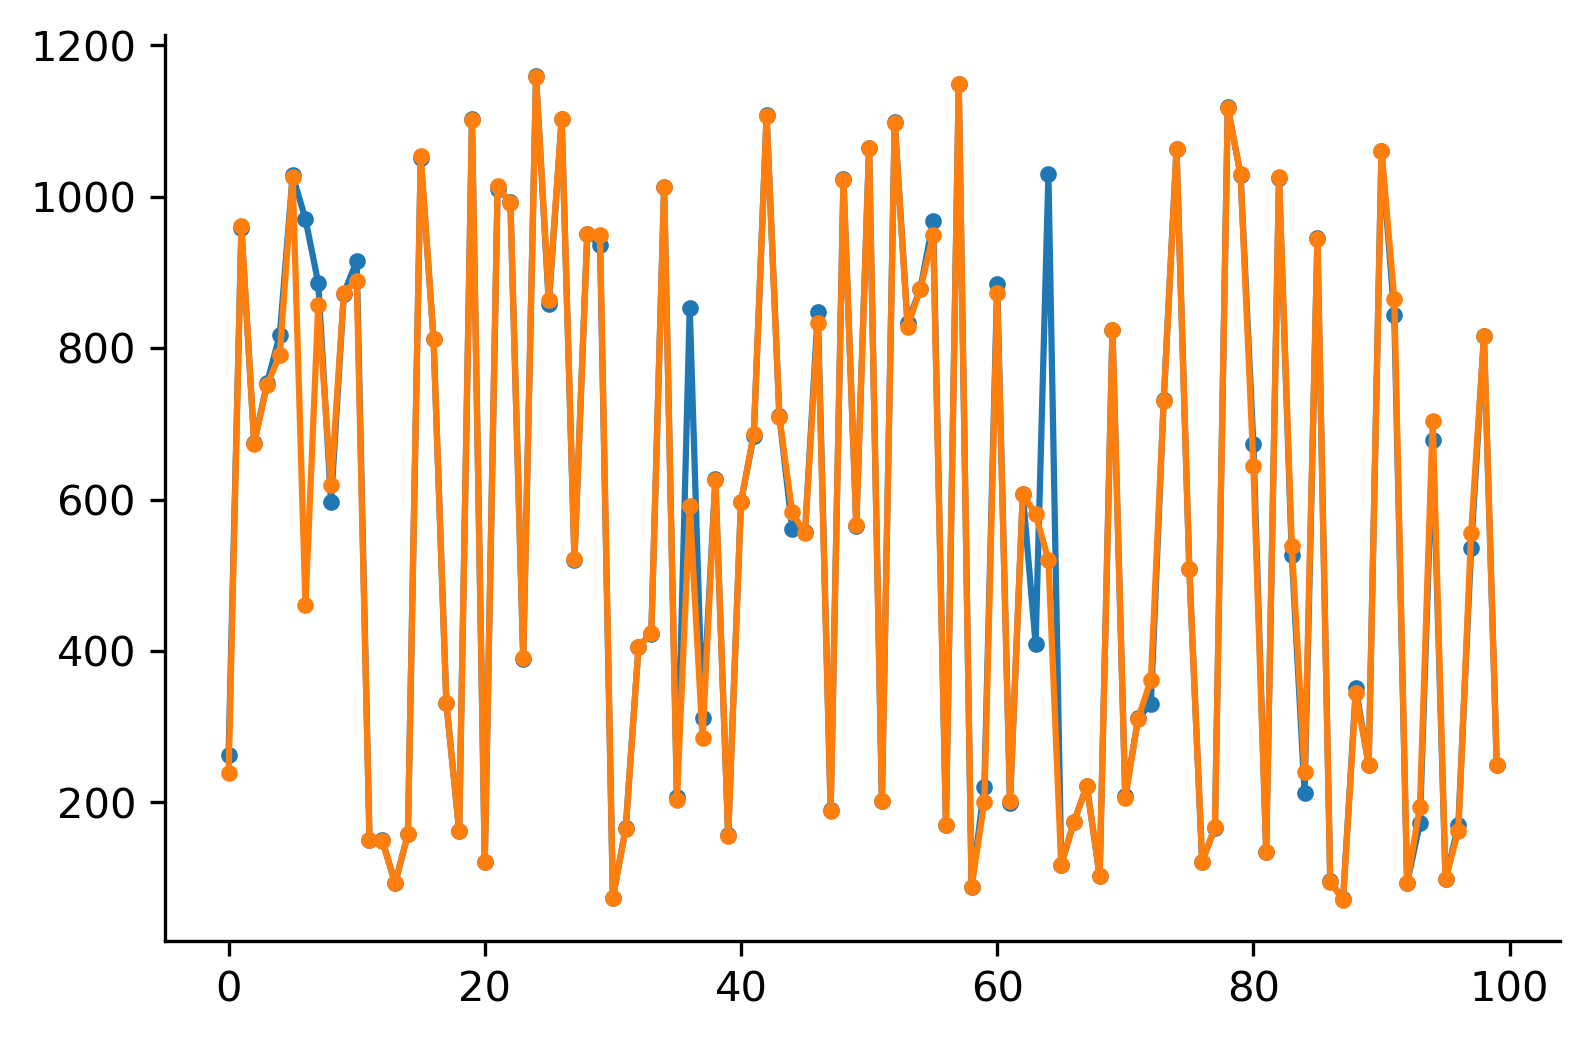

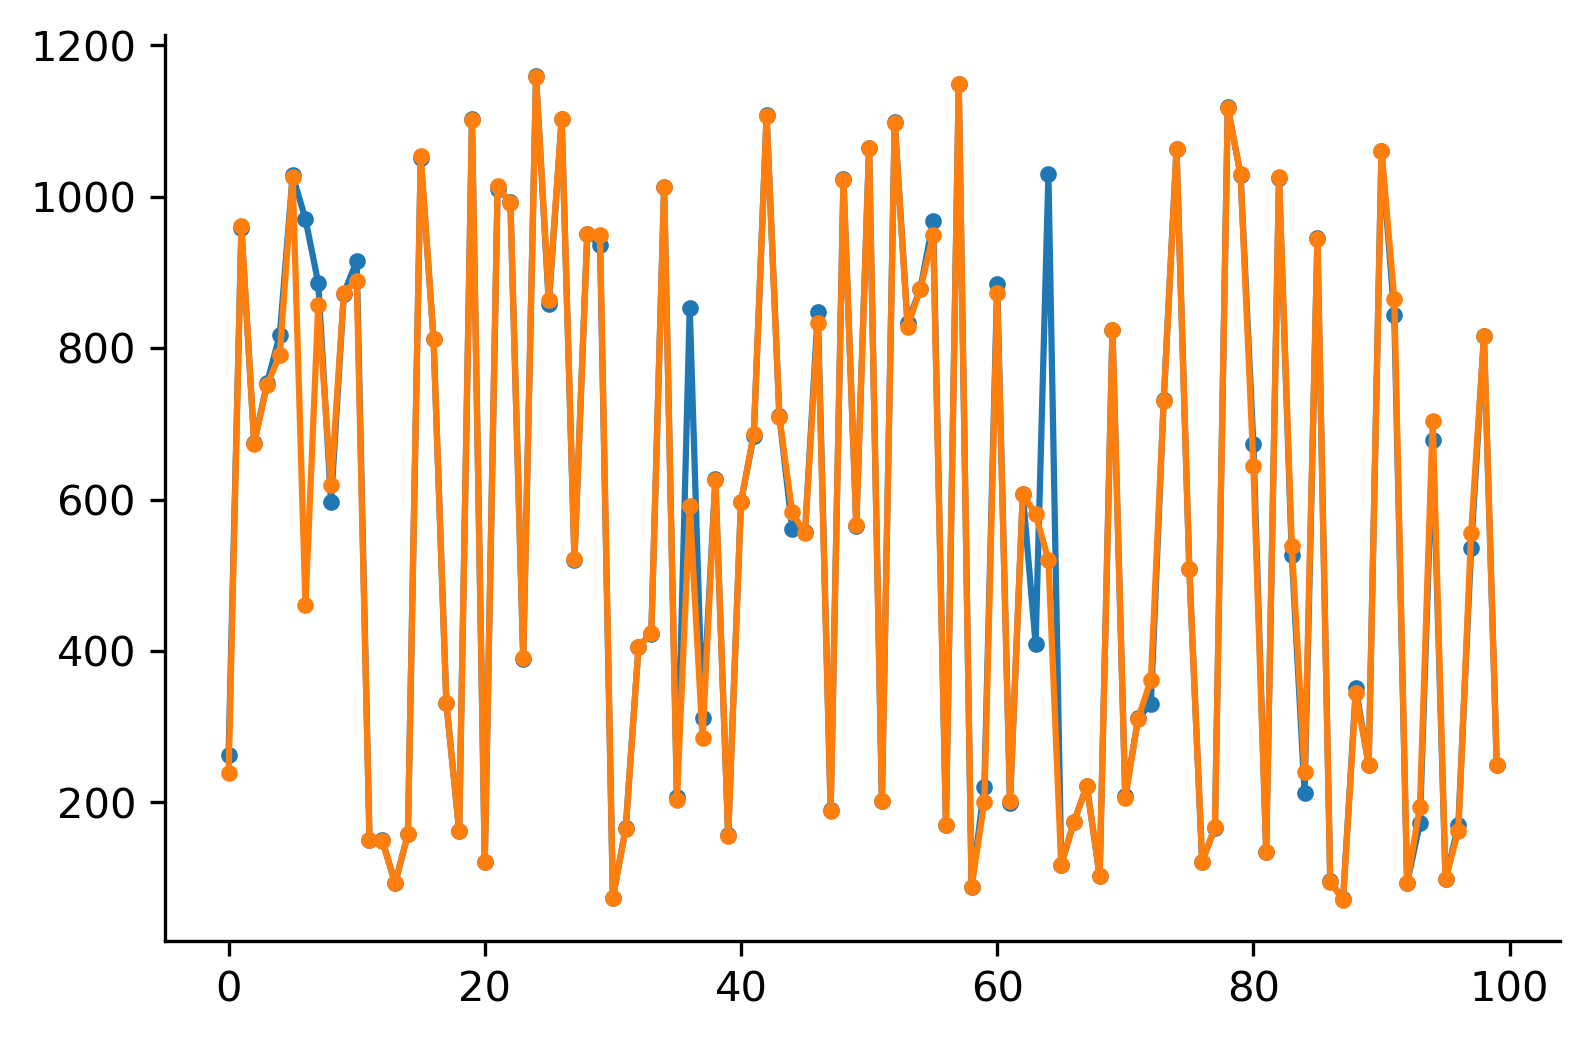

In [6]:
# Evaluate the network

# predicted_data = model.predict(X[-100:, :])

# fp.plot_2d([[y[-100:, 1], predicted_data[-100:, 1]]])

predicted_data = model.predict(validation_X[:100, :])

fp.plot_2d([[validation_y[:100, 1], predicted_data[:100, 1]]])

# predicted_data = model.predict(train_X[:100, :])

# fp.plot_2d([[train_y[:100, 1], predicted_data[:100, 1]]])

In [7]:
# Save the model

# get the path to save the model
save_path = os.path.join(paths.pose_repair_path, target_animal)

# save the model
model.save(save_path)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: J:\Drago Guggiana Nilo\Prey_capture\Pose_repair\cricket\assets


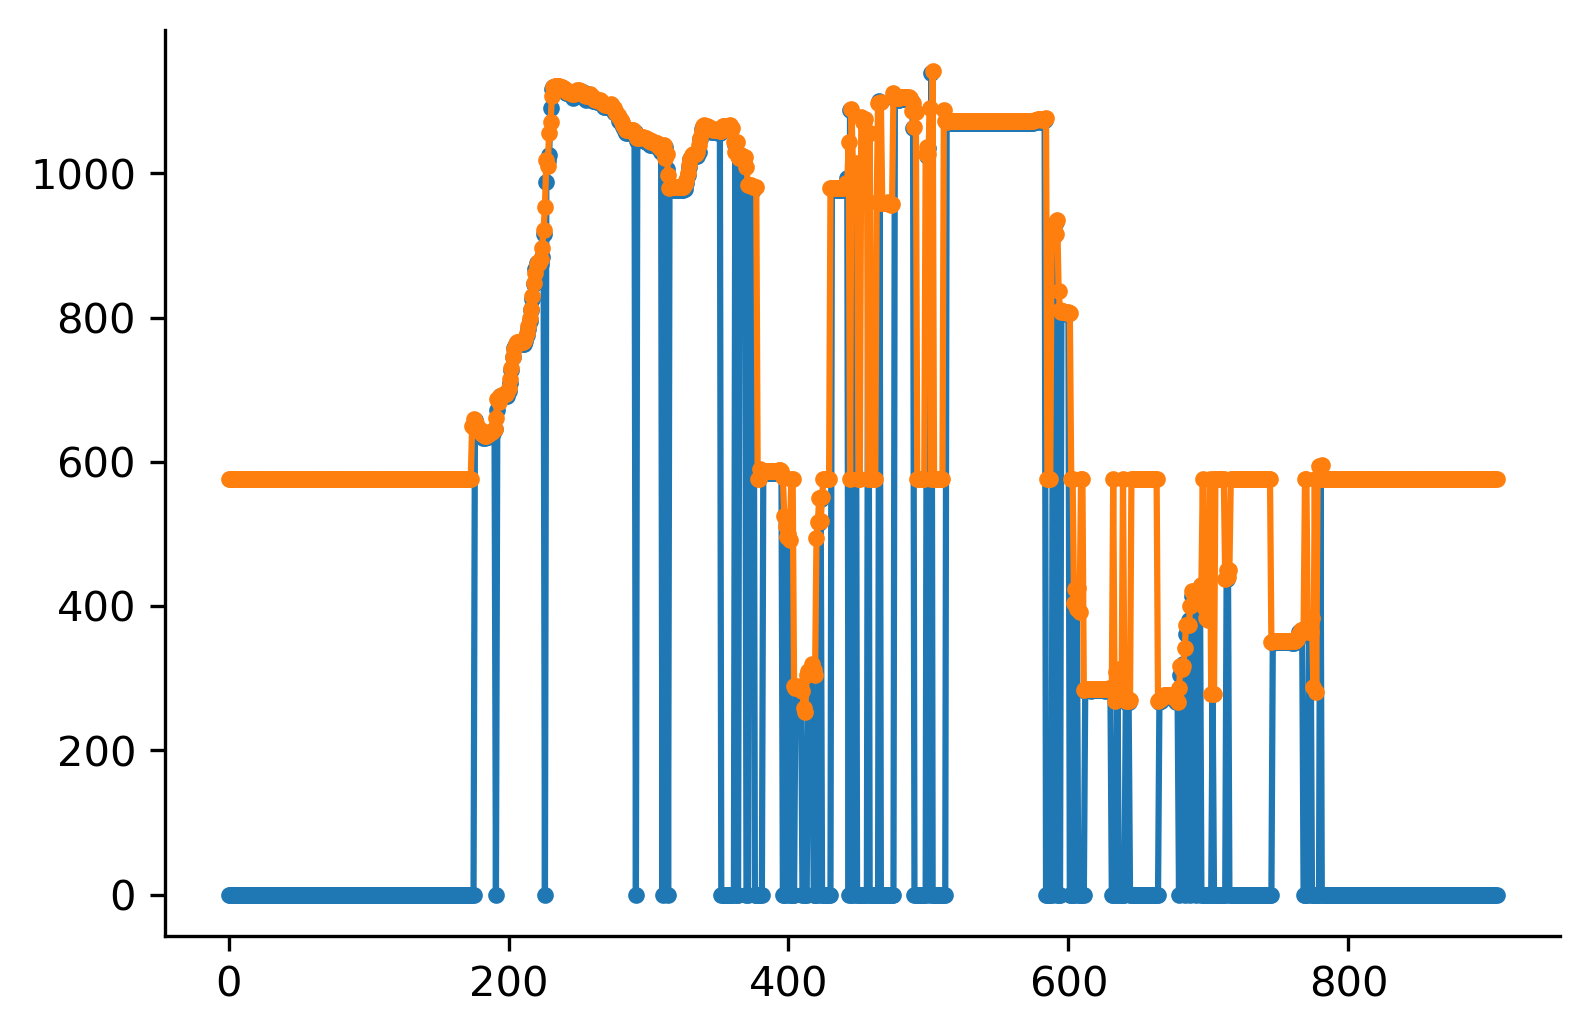

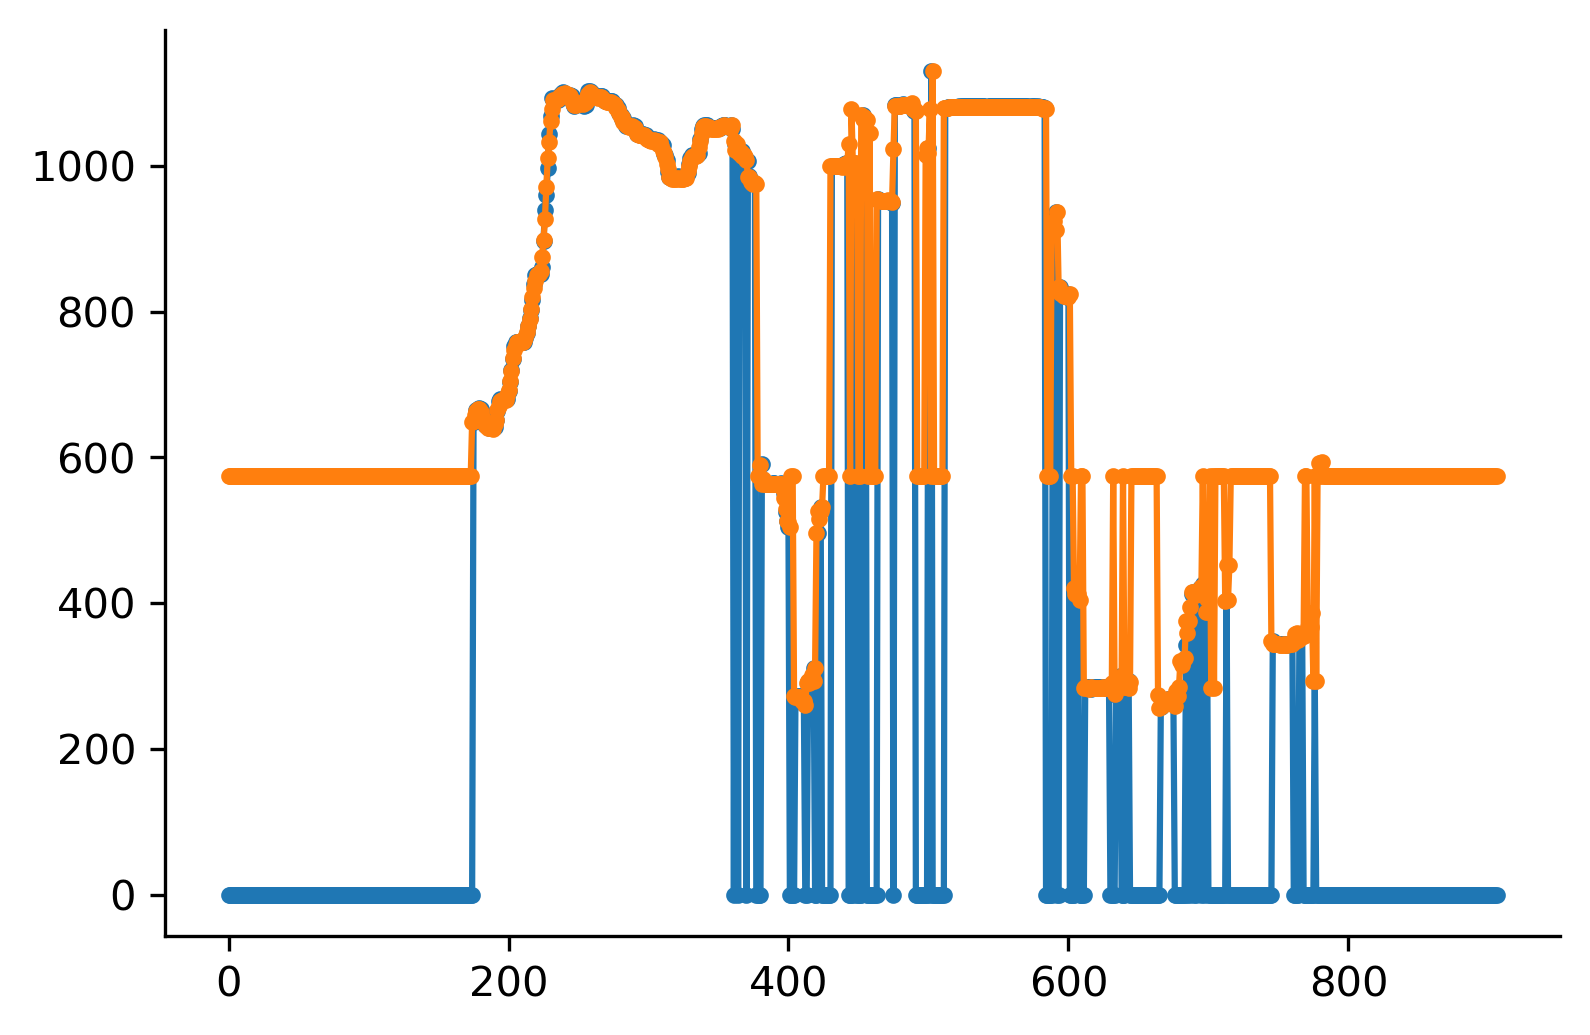

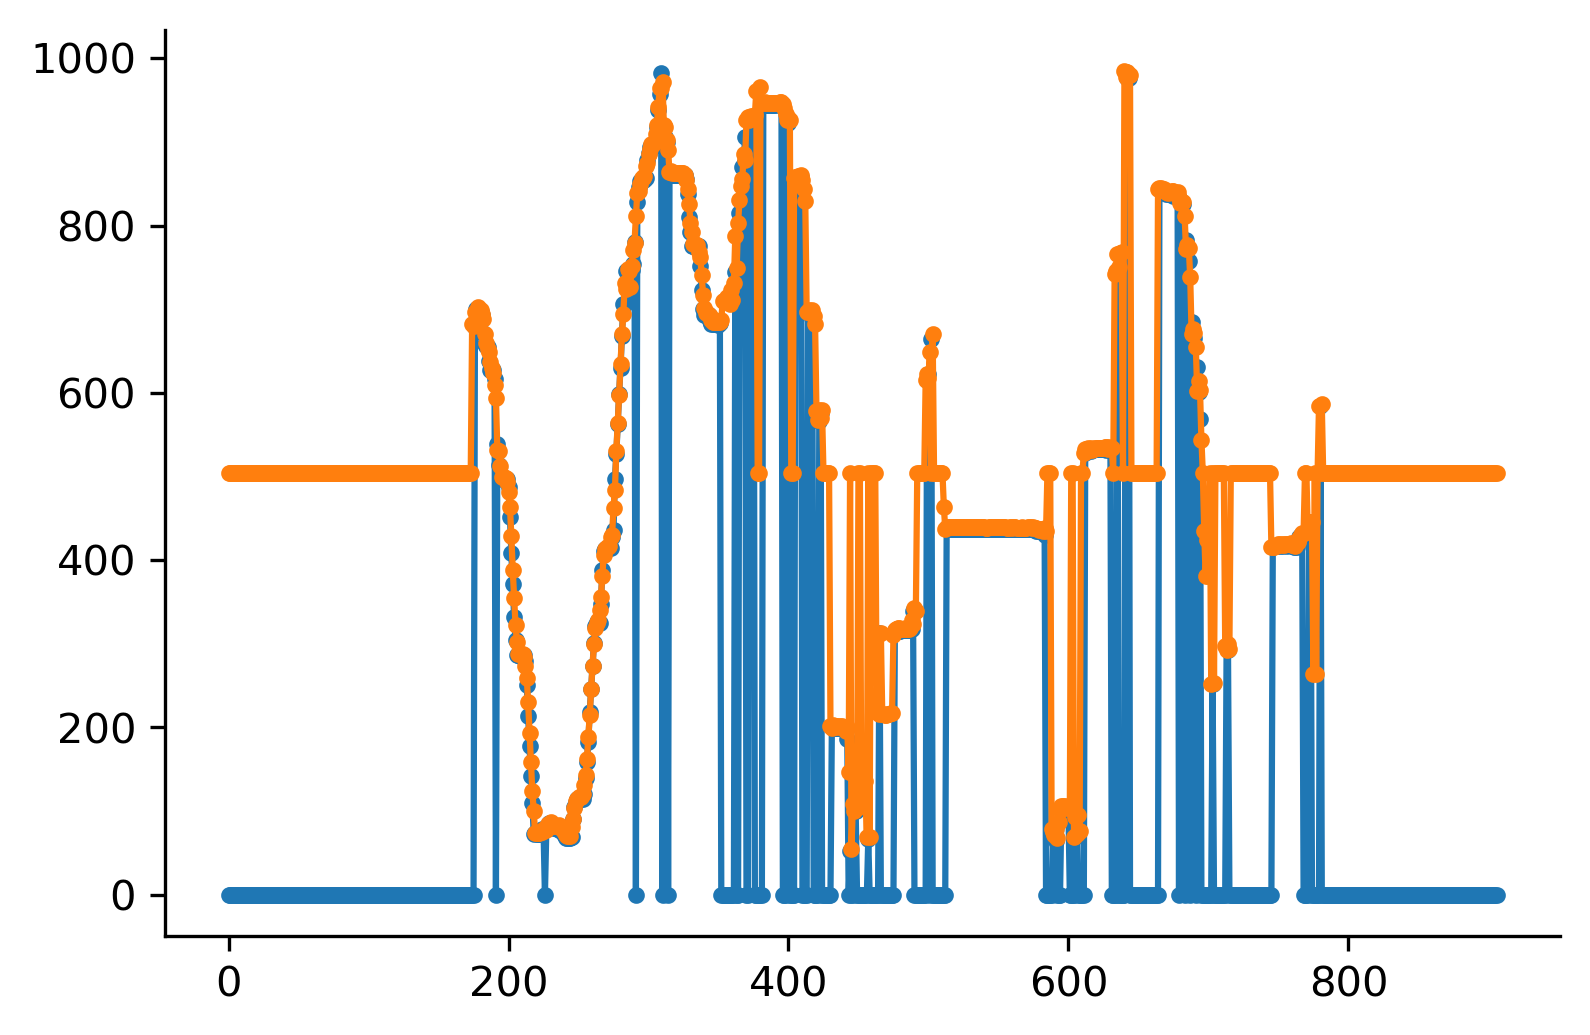

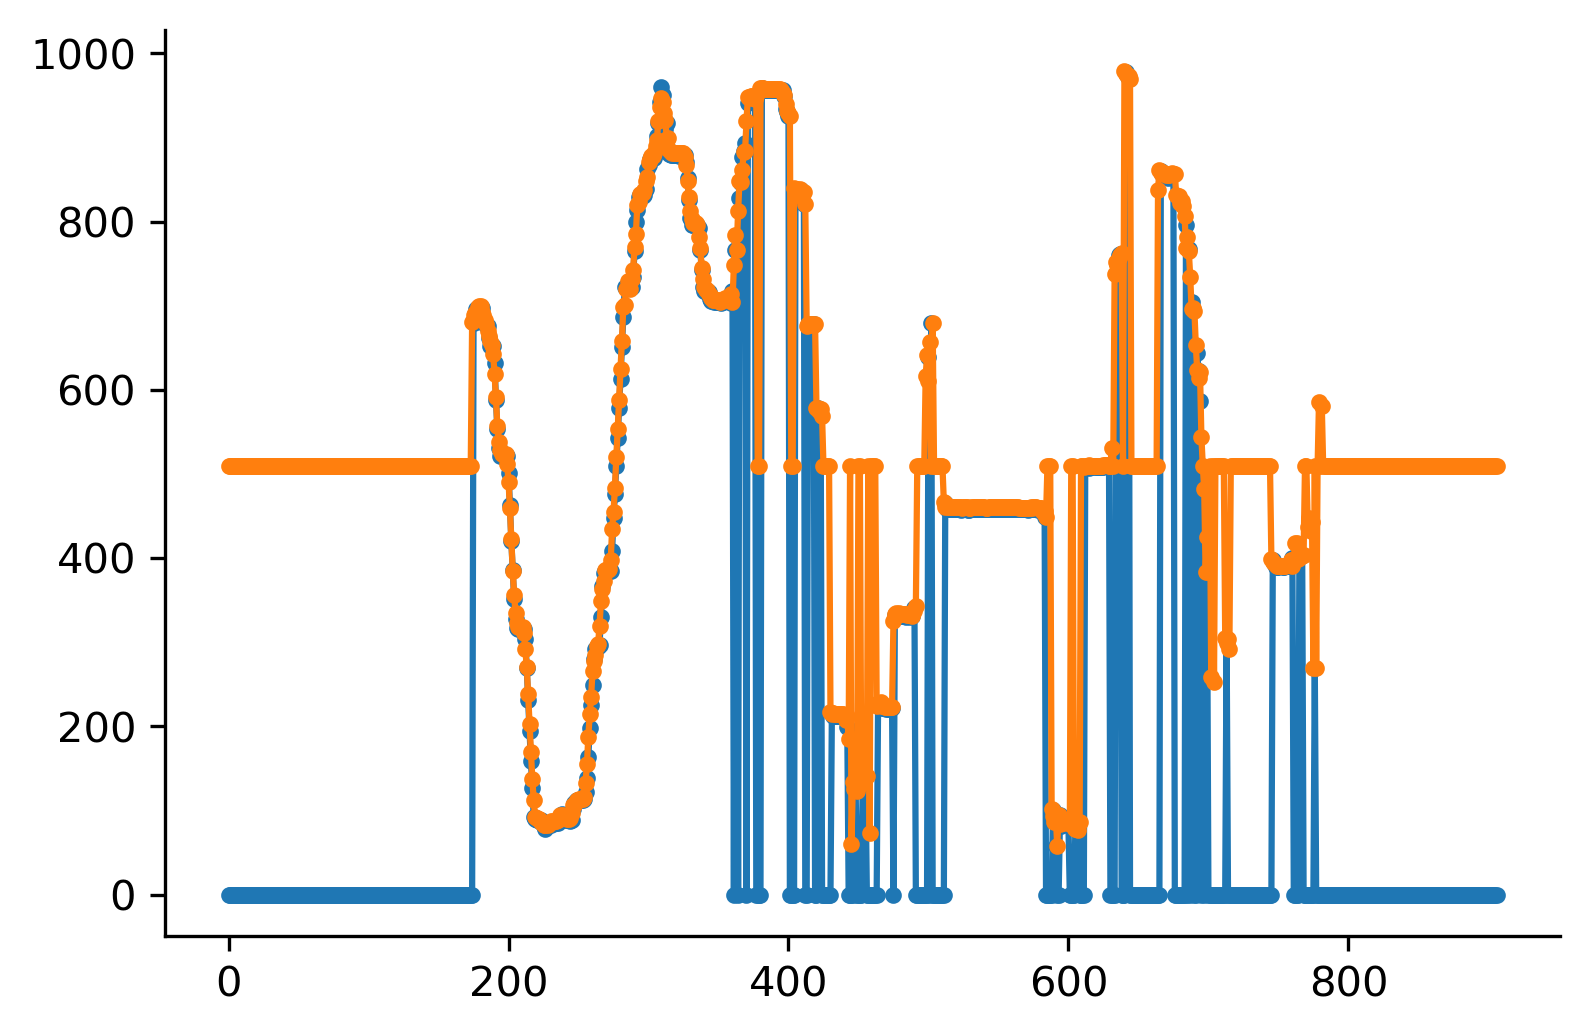

In [8]:
# Evaluate with single trials

# select the target trial
target_trial = 600

# load the corresponding data points
current_points = all_points[target_trial].loc[:, column_list].to_numpy()

# get the number of timepoints
number_timepoints = current_points.shape[0]

# allocate memory for the design matrix
design_matrix = np.zeros((number_timepoints, number_features*delay + number_features))
# pad the data according to the delay
# current_points = np.concatenate((np.zeros((delay, number_features)), current_points), axis=0)
# # assemble the design matrix
# # for all the points
# for points in np.arange(number_timepoints):
#     design_matrix[points, :] = current_points[points:points+delay+1, :].reshape([1, -1])

current_points = np.concatenate((np.zeros((int(delay/2), number_features)), current_points,
                                np.zeros((int(delay/2), number_features))), axis=0)
# assemble the design matrix
# for all the points
for points in np.arange(number_timepoints):
    design_matrix[points, :] = current_points[points:points+delay+1, :].reshape([1, -1])

    
# extract the prediction and validation matrices
design_matrix[np.isnan(design_matrix)] = 0

# eval_X = design_matrix[:, number_features:]
# eval_X = design_matrix
# eval_y = design_matrix[:, :number_features]
eval_X = np.concatenate((design_matrix[:, :number_features*int(delay/2)], 
                    design_matrix[:, -number_features*int(delay/2):]), axis=1)
eval_y = design_matrix[:, number_features*int(delay/2):number_features*int(delay/2)+number_features]

# predict the data
predicted_data = model.predict(eval_X)
# define the target variable
# target_variable = 5
for target_variable in np.arange(number_features):
    # plot against the real data
    fp.plot_2d([[eval_y[:, target_variable], predicted_data[:, target_variable]]])
